In [1]:
# import
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

In [2]:
plt.style.use('ggplot')

# Load the data

In [3]:
# load GoogleDrive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)  # access from Google Drive

folder = './gdrive/My Drive/Deep-Learning/'

# locations

locations = pd.read_csv(folder+'stations.txt', sep=' ', index_col=0)

locations.head(20)

Mounted at /content/gdrive


,database,station_latitude(dec.degree),station_longitude(dec.degree),station_altitude(m)
station_name,,,,
TILLABERI,AMMA-CATCH,14.204300,1.454500,212.0
TOBRE,AMMA-CATCH,10.199100,2.133500,371.0
TARA,AMMA-CATCH,15.251400,-1.585500,335.0
AGOUFOU,AMMA-CATCH,15.360000,-1.470000,340.0
LAWRA,MARLOES,10.866670,-1.483330,305.0
NAVRONGO,MARLOES,10.530000,-1.050000,201.3
OUAHIGOUYA,MARLOES,13.520000,-2.390000,365.0
TAMALE,MARLOES,9.330000,-0.510000,183.3
WA,MARLOES,10.030000,-2.090000,322.7


In [4]:
# import the CMORPH data

df_cmorph = pd.read_csv(folder+'UpdatedResolutions_CMORPH_overlapping.csv', index_col=0)
df_cmorph.index = pd.to_datetime(df_cmorph.index, errors='coerce')

# import the TAMSAT data

df_tamsat = pd.read_csv(folder+'UpdatedResolutions_TAMSAT_overlapping.csv', index_col=0)
df_tamsat.index = pd.to_datetime(df_tamsat.index, errors='coerce')

# import the IMERG data

df_imerg = pd.read_csv(folder+'UpdatedResolutions_IMERG_overlapping.csv', index_col=0)
df_imerg.index = pd.to_datetime(df_imerg.index, errors='coerce')




# check the dataset shapes

print(' ')
print(f'Dataset shapes')
print(f'---' * 10)

print(df_cmorph.shape, df_tamsat.shape, df_imerg.shape)

 
Dataset shapes
------------------------------
(16026, 1027) (16026, 1027) (16026, 1027)


In [5]:
# classify

thr = 1.0  # mm/day, threshold between rainy and wet days

# binary values

df_cmorph['Rain'] = df_cmorph['R[mm]']
df_cmorph['Rain'][df_cmorph['R[mm]'] < thr] = 0.0
df_cmorph['Rain'][df_cmorph['R[mm]'] >= thr] = 1.0

# we will not need the 'R[mm]' column any more

prec = df_cmorph['R[mm]']
df_cmorph.drop(['R[mm]'], axis=1, inplace=True)

df_cmorph

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,latitude,dataset,Rain
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-06-08,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.169223,0.075751,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.298822,1.185205,2.321692,3.045660,3.254830,2.943529,1.136461,0.476312,0.176544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.187106,0.262240,0.221734,14.204300,CMORPH,0.0
2000-06-09,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,...,1.488693,1.740370,1.085444,0.192998,0.000000,6.483722,19.811516,23.006424,18.560978,11.936769,11.024746,10.506308,11.183578,12.820748,15.571081,8.413095,4.135703,5.314629,6.725379,10.718180,16.291904,20.385557,21.129496,18.566637,8.982130,7.301218,6.607963,6.231372,4.383336,4.409812,3.324329,0.642646,0.355685,0.215835,0.074550,0.000000,0.000000,14.204300,CMORPH,0.0
2000-06-10,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,...,16.517967,15.735293,16.264442,14.935356,13.077184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125696,0.000000,0.000000,0.140034,0.116601,0.528398,1.402359,1.180172,0.942927,1.883932,4.107148,6.503812,13.792906,15.689438,16.826096,17.656454,19.203127,16.236609,16.075899,14.863060,13.357284,12.070374,11.942576,10.774127,14.204300,CMORPH,0.0
2000-06-11,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,...,0.285462,0.175417,0.466907,1.377465,0.650208,14.934494,10.356865,8.188148,8.380214,6.295541,5.732327,5.205595,5.487986,5.166414,3.449150,2.022675,2.205905,2.067136,1.933892,1.227386,0.520791,0.000000,0.000000,0.000000,0.000000,0.000000,0.088741,0.117984,0.122882,0.109459,0.124830,0.090816,0.084605,0.200180,0.392871,0.256930,0.000000,14.204300,CMORPH,0.0
2000-06-12,0.00,0.00,0.00,0.00,0.217778,0.141667,0.00,0.00,0.00,0.00,0.00,0.00,0.245,0.231111,0.131667,0.268741,0.128191,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,...,0.000000,0.000000,0.114463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100878,1.468175,0.932161,5.676294,2.758598,1.274993,0.653104,0.365603,0.000000,0.082567,0.258888,0.147319,1.292727,2.103040,2.557600,2.628348,2.530024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.204300,CMORPH,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-26,0.00,0.00,3.38,0.00,0.000000,2.520000,1.09,1.44,2.39,1.29,2.17,2.06,6.760,8.809999,23.469999,26.930000,29.920000,19.639999,26.449999,22.769999,

In [6]:
# labels are the rainfall intermittency sequence

y = df_cmorph['Rain']
print(y.shape, prec.shape)

df = df_cmorph['latitude']
x_cmorph = df_cmorph.drop(['Rain',  'dataset', 'latitude'], axis=1)
x_tamsat = df_tamsat.drop(['R[mm]', 'dataset', 'latitude'], axis=1)
x_imerg  = df_imerg.drop([ 'R[mm]', 'dataset', 'latitude'], axis=1)
print(x_cmorph.shape, x_tamsat.shape, x_imerg.shape)



# reshape to (x, 32, 32)

pixels = 32  # insert 32 for 32 * 32, 16 for 16 * 16 etc.


x_cmorph = x_cmorph.to_numpy()
x_cmorph = np.reshape(x_cmorph, (len(x_cmorph), pixels, pixels))  # is the reshape correct?

x_tamsat = x_tamsat.to_numpy()
x_tamsat = np.reshape(x_tamsat, (len(x_tamsat), pixels, pixels))

x_imerg = x_imerg.to_numpy()
x_imerg = np.reshape(x_imerg, (len(x_imerg), pixels, pixels))

print(x_cmorph.shape, x_tamsat.shape, x_imerg.shape)




# the input has to be (x, 32, 32, 3)

x = np.zeros((len(df_cmorph), pixels, pixels, 3))

x[:, :, :, 0] = x_cmorph
x[:, :, :, 1] = x_tamsat
x[:, :, :, 2] = x_imerg

print(' ')
print(f'Final shape')
print(f'---' * 10)

print(x.shape)

(16026,) (16026,)
(16026, 1024) (16026, 1024) (16026, 1024)
(16026, 32, 32) (16026, 32, 32) (16026, 32, 32)
 
Final shape
------------------------------
(16026, 32, 32, 3)


# Pre-processing

Wet-day ratio:

In [ ]:
per = sum(y) * 100 / len(y)
print(f'The percentage of rainy days in the dataset is {per:.2f}%.')

The percentage of rainy days in the dataset is 28.25%.


Normalization of input

In [7]:
# maximum pixel value CMORPH
m_CMORPH = np.max(np.max(x[:,:,:,0]))
print('maximum pixel value of all collumns:', m_CMORPH)

# maximum pixel value TAMSAT
m_TAMSAT = np.max(np.max(x[:,:,:,1]))
print('maximum pixel value of all collumns:', m_TAMSAT)

# maximum pixel value IMERG
m_IMERG = np.max(np.max(x[:,:,:,2]))
print('maximum pixel value of all collumns:', m_IMERG)

maximum pixel value of all collumns: 273.5370483398437
maximum pixel value of all collumns: 157.0
maximum pixel value of all collumns: 413.2111111111112


In [8]:
# scale the data for the maximum pixel value of all pixels

x[:,:,:,0] = x[:,:,:,0] / m_CMORPH
x[:,:,:,1] = x[:,:,:,1] / m_TAMSAT
x[:,:,:,2] = x[:,:,:,2] / m_IMERG

print(np.max(np.max(x[:,:,:,0])), np.max(np.max(x[:,:,:,1])), np.max(np.max(x[:,:,:,2])))

1.0 1.0 1.0


In [ ]:
# x[:,:,:,0]  # checking MinMaxScaler

## Dataset transformation to be used as input for the CNN

split training:

In [9]:
# training, validation and test datasets

from sklearn.model_selection import train_test_split

# get the intial indices
ind = np.arange(len(x))

# x_tra, x_val, y_tra, y_val = train_test_split(x, y, test_size=0.10, random_state=42)
x_tra, x_tst, y_tra, y_tst, ind_tra, ind_tst = train_test_split(x, y, ind, test_size=0.30, random_state=42)

for name, data in zip(['TRAINING', 'TEST    '], [x_tra, x_tst]):
  print(f'The {name} dataset is {len(data)} rows long.')

The TRAINING dataset is 11218 rows long.
The TEST     dataset is 4808 rows long.


In [10]:
print(x_tra.shape, x_tst.shape, y_tra.shape, y_tst.shape)

(11218, 32, 32, 3) (4808, 32, 32, 3) (11218,) (4808,)


Check training and test index

In [11]:
print(len(ind_tra), ind_tra)
print(len(ind_tst), ind_tst)

11218 [ 3100  6390 11356 ...   860 15795  7270]
4808 [ 4829  1962  2546 ...  5458 12523  3244]


Visualize random image from TRAINING dataset:

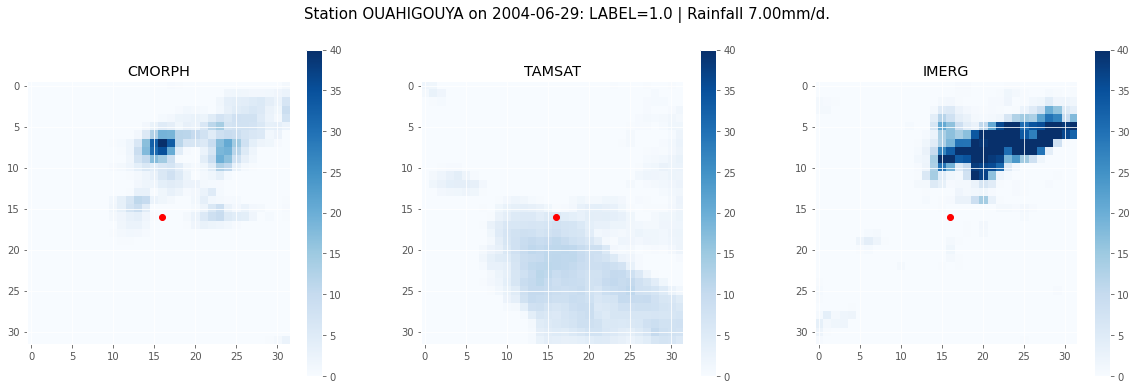

In [12]:
# select random image
ix = random.randint(0, x_tra.shape[0])
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ ind_tra[ ix ] ] ][0]


# set minimum and maximum in colorbars
prec_max = max( np.max(x[ix,:,:,0]) * m_CMORPH, np.max(x[ix,:,:,1]) * m_TAMSAT, np.max(x[ix,:,:,2]) * m_IMERG )
prec_max = min(prec_max, 40)  # set a threshold so it can be visible
# print(prec_max)
 

# create subplots
plt.figure(figsize=(20, 6))
plt.suptitle(f'Station {station} on {df.index[ ind_tra[ix] ].date()}: LABEL={y_tra[ix]} | Rainfall {prec[ ind_tra[ ix ]]:.2f}mm/d.', fontsize=15)
plt.subplot()

plt.subplot(131)
img = x_tra[ix, :, :, 0] * m_CMORPH
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'CMORPH')  


plt.subplot(132)
img = x_tra[ix, :, :, 1] * m_TAMSAT
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'TAMSAT')  


plt.subplot(133)
img = x_tra[ix, :, :, 2] * m_IMERG
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.title(f'IMERG')


plt.colorbar();

### Similarity indices:

1. Correlation coefficient

In [ ]:
corr_CMORPH_TAMSAT = np.corrcoef( x_tra[ix, :, :, 0].flatten(), x_tra[ix, :, :, 1].flatten() )[0][1]
corr_CMORPH_IMERG  = np.corrcoef( x_tra[ix, :, :, 0].flatten(), x_tra[ix, :, :, 2].flatten() )[0][1]
corr_TAMSAT_IMERG  = np.corrcoef( x_tra[ix, :, :, 1].flatten(), x_tra[ix, :, :, 2].flatten() )[0][1]

print(f'Correlation between CMORPH and TAMSAT:  {corr_CMORPH_TAMSAT:.2f}.')
print(f'Correlation between CMORPH and IMERG:   {corr_CMORPH_IMERG:.2f}.')
print(f'Correlation between TAMSAT and IMERG:   {corr_TAMSAT_IMERG:.2f}.')

Correlation between CMORPH and TAMSAT:  -0.12.
Correlation between CMORPH and IMERG:   0.24.
Correlation between TAMSAT and IMERG:   0.03.


2. Co-occurrence matrix (coma)

First create **X** classes representing different intervals of normalized rain intensities (0.0 - 0.1, 0.1 - 0.2, etc.)

In [ ]:
num_classes = 50  # choose the number of classes to be created
div = 1 / num_classes

CMORPH_classes = ((x_tra[ix, :, :, 0] // div) ).astype(int)
TAMSAT_classes = ((x_tra[ix, :, :, 1] // div) ).astype(int)
IMERG_classes  = ((x_tra[ix, :, :, 2] // div) ).astype(int)

Let's see how many unique classes each image has.

In [ ]:
print('CMORPH has the following classes: ', np.unique( CMORPH_classes ))
print('TAMSAT has the following classes: ', np.unique( TAMSAT_classes ))
print('IMERG  has the following classes: ', np.unique( IMERG_classes  ))

CMORPH has the following classes:  [0 1 2 3]
TAMSAT has the following classes:  [ 0  1  2  3  4  5  7  9 15 20 21 23 24 25 30 35 37 46 48 49]
IMERG  has the following classes:  [0 1 2 3 4 5 6 7 8]


Calculate the co-occurance matrices

In [ ]:
from skimage.feature import greycomatrix, greycoprops

angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
levels = max( np.max(CMORPH_classes), np.max(TAMSAT_classes), np.max(IMERG_classes) ) + 1  # maximum values will be used as levels
# print(levels)

coma_CMORPH = greycomatrix( CMORPH_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_CMORPH  = greycoprops( coma_CMORPH, prop='homogeneity' )[0, 0]

coma_TAMSAT = greycomatrix( TAMSAT_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_TAMSAT  = greycoprops( coma_TAMSAT, prop='homogeneity' )[0, 0]

coma_IMERG  = greycomatrix( IMERG_classes , distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_IMERG  = greycoprops( coma_IMERG, prop='homogeneity' )[0, 0]


# print shape and homogeneity
print(f'CMORPH has shape of: {coma_CMORPH.shape} and homogeneity: {homogeneity_CMORPH:.2f}.' )
print(f'TAMSAT has shape of: {coma_TAMSAT.shape} and homogeneity: {homogeneity_TAMSAT:.2f}.' )
print(f'IMERG  has shape of: {coma_IMERG.shape} and homogeneity: {homogeneity_IMERG:.2f}.' )

CMORPH has shape of: (50, 50, 1, 4) and homogeneity: 0.95.
TAMSAT has shape of: (50, 50, 1, 4) and homogeneity: 0.85.
IMERG  has shape of: (50, 50, 1, 4) and homogeneity: 0.93.


From co-occurance matrices to co-occurence vectors. We will simplify the above vector by counting all relations only once (np.unique) so that the generated outputs have the same lengths.

In [ ]:
# matrices to vectors
cove_CMORPH = coma_CMORPH.flatten()  # np.unique
cove_TAMSAT = coma_TAMSAT.flatten()  # np.unique
cove_IMERG  = coma_IMERG.flatten()  # np.unique

# print length
print(f'CMORPH has length of: {cove_CMORPH.shape}.' )
print(f'TAMSAT has length of: {cove_TAMSAT.shape}.' )
print(f'IMERG  has length of: {cove_IMERG.shape}.' )

CMORPH has length of: (10000,).
TAMSAT has length of: (10000,).
IMERG  has length of: (10000,).


Compute the Jensen-Shannon distance of the three different co-occurence matrices. This function takes two probability functions (spatial signatures in our case) A and B, and calculates entropy values (H). 

The Jenson-Shannon distance is a value between 0 and 1, where 0 means that two probability functions are identical, and 1 means that they have nothing in common.

In [ ]:
from scipy.spatial import distance

js_CMORPH_TAMSAT = distance.jensenshannon(cove_CMORPH, cove_TAMSAT)
js_CMORPH_IMERG  = distance.jensenshannon(cove_CMORPH, cove_IMERG)
js_TAMSAT_IMERG  = distance.jensenshannon(cove_IMERG, cove_TAMSAT)

# print
print(f'CMORPH and TAMSAT have a Jensen-Shannon distance of: {js_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Jensen-Shannon distance of: {js_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Jensen-Shannon distance of: {js_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Jensen-Shannon distance of: 0.41.
CMORPH and IMERG  have a Jensen-Shannon distance of: 0.15.
TAMSAT and IMERG  have a Jensen-Shannon distance of: 0.40.


3. Perceptual hash

Average out (32, 32) to (8, 8)

In [ ]:
CMORPH_64 = x_tra[ix, :, :, 0].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
TAMSAT_64 = x_tra[ix, :, :, 1].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
IMERG_64  = x_tra[ix, :, :, 2].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)

# print shapes
print(f'CMORPH has shape of: {CMORPH_64.shape}.' )
print(f'TAMSAT has shape of: {TAMSAT_64.shape}.' )
print(f'IMERG  has shape of: {IMERG_64.shape}.' )

CMORPH has shape of: (8, 8).
TAMSAT has shape of: (8, 8).
IMERG  has shape of: (8, 8).


Calculate the hash

In [ ]:
CMORPH_64 = ( CMORPH_64 > CMORPH_64.mean() ).astype(int)
TAMSAT_64 = ( TAMSAT_64 > TAMSAT_64.mean() ).astype(int)
IMERG_64  = ( IMERG_64  > IMERG_64.mean()  ).astype(int)

Calculate Hamming's distance

In [ ]:
from scipy.spatial import distance

# 0: identical and 1: opposite
hamming_CMORPH_TAMSAT = distance.hamming(CMORPH_64.flatten(), TAMSAT_64.flatten())
hamming_CMORPH_IMERG  = distance.hamming(CMORPH_64.flatten(), IMERG_64.flatten())
hamming_TAMSAT_IMERG  = distance.hamming(IMERG_64.flatten() , TAMSAT_64.flatten())


# print
print(f'CMORPH and TAMSAT have a Hamming distance of: {hamming_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Hamming distance of: {hamming_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Hamming distance of: {hamming_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Hamming distance of: 0.42.
CMORPH and IMERG  have a Hamming distance of: 0.19.
TAMSAT and IMERG  have a Hamming distance of: 0.39.


# Misclassification index

### Load the miss_index

In [14]:
miss_index = np.loadtxt(folder+'MissIndexMajorityModel2.txt')

### Interpret the misclassified index

In [15]:
print('Number of missclassified days:', len(miss_index), 'out of', len(y_tst), 'in the test dataset')

Number of missclassified days: 1136 out of 4808 in the test dataset


First step is to covert the miss_index sequence from representing the test dataset to the index of the whole dataset: 

In [16]:
miss_index_initial = np.sort( ind_tst[ miss_index.astype(int) ] )
miss_index_initial[0:100]

array([  15,   27,   36,   39,   41,   46,   47,   63,   70,   84,   88,
        101,  168,  180,  181,  185,  200,  221,  257,  327,  346,  357,
        373,  376,  379,  385,  388,  399,  410,  420,  455,  465,  473,
        483,  499,  510,  528,  530,  535,  542,  543,  613,  624,  637,
        642,  668,  673,  676,  683,  696,  708,  732,  761,  772,  800,
        820,  829,  833,  836,  850,  856,  907,  908,  962,  965,  967,
        977,  978, 1011, 1034, 1041, 1053, 1110, 1119, 1123, 1142, 1147,
       1157, 1160, 1190, 1217, 1219, 1225, 1237, 1250, 1253, 1275, 1277,
       1282, 1288, 1297, 1303, 1315, 1350, 1427, 1443, 1451, 1457, 1459,
       1575])

In [17]:
time_error_daily = np.sum(np.diff(miss_index_initial, n=1) == 1)
print(f'{time_error_daily:.0f} times misclassifications happen in two consecutive days.')
print(f'Can we assume that {2 * time_error_daily:.0f} misclassifications out of all happen because of timing error in the daily scale?')

91 times misclassifications happen in two consecutive days.
Can we assume that 182 misclassifications out of all happen because of timing error in the daily scale?


Get the index of the instances of the test dataset where this and the next instance are misclassified:

In [18]:
time_error_INDEX = miss_index_initial[ np.where(np.diff(miss_index_initial, n=1) == 1)[0] ]
print(time_error_INDEX)

[   46   180   542   907   977  1575  1743  1746  2328  2613  2614  2615
  2655  2726  2753  2864  2928  3014  3037  3076  3105  3106  3115  3221
  3378  3467  3570  3577  3702  3836  3837  3851  3886  3909  4003  4073
  4093  4097  4128  4201  4237  4303  4403  4560  4629  4638  4705  4720
  4745  4754  4785  5225  5363  5651  5688  6595  6692  7820  8121  8443
  9124  9619 10777 11674 11735 11853 11895 12445 12654 12664 12949 13530
 13804 13805 13954 14046 14050 14063 14132 14367 14464 14494 14795 15048
 15199 15233 15355 15392 15778 15782 15831]


In [19]:
print(miss_index_initial[0:80])

[  15   27   36   39   41   46   47   63   70   84   88  101  168  180
  181  185  200  221  257  327  346  357  373  376  379  385  388  399
  410  420  455  465  473  483  499  510  528  530  535  542  543  613
  624  637  642  668  673  676  683  696  708  732  761  772  800  820
  829  833  836  850  856  907  908  962  965  967  977  978 1011 1034
 1041 1053 1110 1119 1123 1142 1147 1157 1160 1190]


The next step is to visually check if our assumptions holds true: For every pair of consecutive misclassification, the one time instance of one data source should feature the conditions that match the other data source and vice versa.

In [20]:
input_st_CMORPH = x[:, :, :, 0]
input_st_TAMSAT = x[:, :, :, 1]
input_st_IMERG  = x[:, :, :, 2]
output_testing = y_tst

print('Shapes of datasets')
print(input_st_IMERG.shape, output_testing.shape)

Shapes of datasets
(16026, 32, 32) (4808,)


### 1. to visualize all the misclassifications and the next days:

In [ ]:
for ix in time_error_INDEX:

  station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ind_tst[ix]] ][0]

  # set minimum and maximum in colorbars
  prec_max = max( np.max(input_st_CMORPH[ix,:,:]) * m_CMORPH, np.max(input_st_TAMSAT[ix,:,:]) * m_TAMSAT, np.max(input_st_IMERG[ix,:,:]) * m_IMERG )
  prec_max = min(prec_max, 40)  # set a threshold so it can be visible


  # FOR index = IX

  # create subplots
  plt.figure(figsize=(20, 6))
  plt.suptitle(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: LABEL={y_tst[ix]} | Rainfall {prec[ ind_tst[ ix ]]:.2f}mm/d | output={y_mod[ix][0]:.2f} out of 3.', fontsize=15)
  plt.subplot()

  plt.subplot(131)
  img = input_st_CMORPH[ix, :, :] * m_CMORPH
  # plot image
  plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
  plt.plot(pixels/2, pixels/2, 'ro')
  plt.colorbar()
  plt.title(f'CMORPH output={y_mod_CMORPH[ix][0]:.2f} out of 1.')  


  plt.subplot(132)
  img = input_st_TAMSAT[ix, :, :] * m_TAMSAT
  # plot image
  plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
  plt.plot(pixels/2, pixels/2, 'ro')
  plt.colorbar()
  plt.title(f'TAMSAT output={y_mod_TAMSAT[ix][0]:.2f} out of 1.')   


  plt.subplot(133)
  img = input_st_IMERG[ix, :, :] * m_IMERG
  # plot image
  plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
  plt.plot(pixels/2, pixels/2, 'ro')
  plt.colorbar()
  plt.title(f'IMERG output={y_mod_IMERG[ix][0]:.2f} out of 1.');


  # FOR index = IX + 1
  ix +=1

  # create subplots
  plt.figure(figsize=(20, 6))
  plt.suptitle(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: LABEL={y_tst[ix]} | Rainfall {prec[ ind_tst[ ix ]]:.2f}mm/d | output={y_mod[ix][0]:.2f} out of 3.', fontsize=15)
  plt.subplot()

  plt.subplot(131)
  img = input_st_CMORPH[ix, :, :] * m_CMORPH
  # plot image
  plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
  plt.plot(pixels/2, pixels/2, 'ro')
  plt.colorbar()
  plt.title(f'CMORPH output={y_mod_CMORPH[ix][0]:.2f} out of 1.')  


  plt.subplot(132)
  img = input_st_TAMSAT[ix, :, :] * m_TAMSAT
  # plot image
  plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
  plt.plot(pixels/2, pixels/2, 'ro')
  plt.colorbar()
  plt.title(f'TAMSAT output={y_mod_TAMSAT[ix][0]:.2f} out of 1.')   


  plt.subplot(133)
  img = input_st_IMERG[ix, :, :] * m_IMERG
  # plot image
  plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
  plt.plot(pixels/2, pixels/2, 'ro')
  plt.colorbar()
  plt.title(f'IMERG output={y_mod_IMERG[ix][0]:.2f} out of 1.');  

### 2. to visualize random misclassifications and the next days:

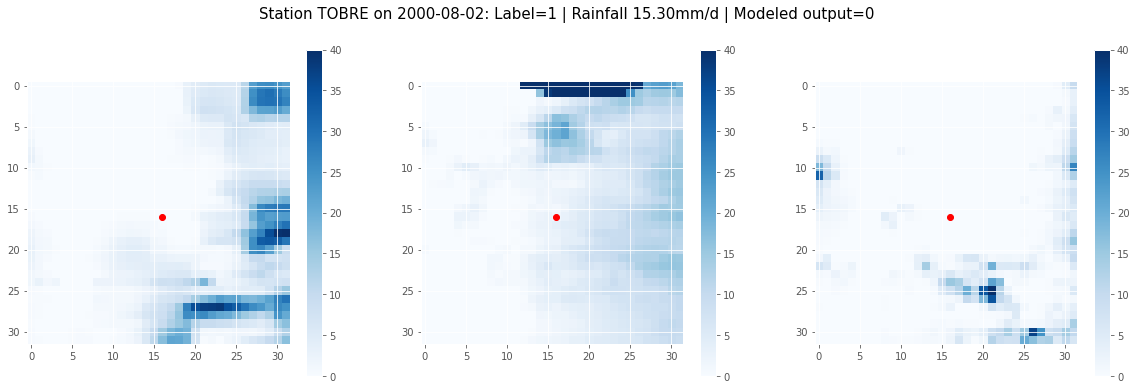

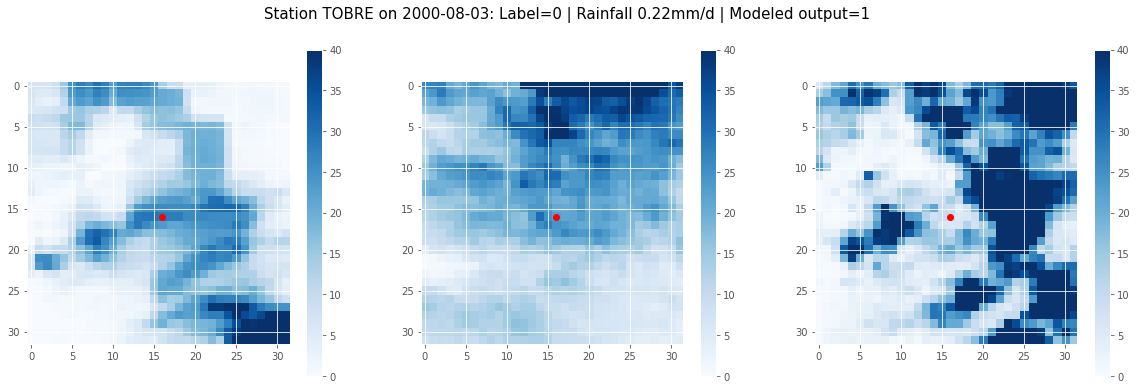

In [39]:
# select random image
ix = time_error_INDEX[random.randint(0, len(time_error_INDEX))].astype(int)
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ix] ][0]

# set minimum and maximum in colorbars
prec_max = max( np.max(input_st_CMORPH[ix,:,:]) * m_CMORPH, np.max(input_st_TAMSAT[ix,:,:]) * m_TAMSAT, np.max(input_st_IMERG[ix,:,:]) * m_IMERG )
prec_max = min(prec_max, 40)  # set a threshold so it can be visible


# FOR index = IX
if y[ ix ] == 0.0:
  modeled_output = 1.0
else:
  modeled_output = 0.0


# create subplots
plt.figure(figsize=(20, 6))
plt.suptitle(f'Station {station} on {df.index[ ix ].date()}: Label={y[ ix ]:.0f} | Rainfall {prec[ ix ]:.2f}mm/d | Modeled output={modeled_output:.0f}', fontsize=15)
plt.subplot()


plt.subplot(131)
img = input_st_CMORPH[ix, :, :] * m_CMORPH
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
# plt.title(f'CMORPH output={y_mod_CMORPH[ix][0]:.2f} out of 1.')  


plt.subplot(132)
img = input_st_TAMSAT[ix, :, :] * m_TAMSAT
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
# plt.title(f'TAMSAT output={y_mod_TAMSAT[ix][0]:.2f} out of 1.')   


plt.subplot(133)
img = input_st_IMERG[ix, :, :] * m_IMERG
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
# plt.title(f'IMERG output={y_mod_IMERG[ix][0]:.2f} out of 1.')


# FOR index = IX + 1
ix +=1
if y[ ix ] == 0.0:
  modeled_output = 1.0
else:
  modeled_output = 0.0


# create subplots
plt.figure(figsize=(20, 6))
plt.suptitle(f'Station {station} on {df.index[ ix ].date()}: Label={y[ ix ]:.0f} | Rainfall {prec[ ix ]:.2f}mm/d | Modeled output={modeled_output:.0f}', fontsize=15)
plt.subplot()


plt.subplot(131)
img = input_st_CMORPH[ix, :, :] * m_CMORPH
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
# plt.title(f'CMORPH output={y_mod_CMORPH[ix][0]:.2f} out of 1.')  


plt.subplot(132)
img = input_st_TAMSAT[ix, :, :] * m_TAMSAT
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
# plt.title(f'TAMSAT output={y_mod_TAMSAT[ix][0]:.2f} out of 1.')   


plt.subplot(133)
img = input_st_IMERG[ix, :, :] * m_IMERG
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar();
# plt.title(f'IMERG output={y_mod_IMERG[ix][0]:.2f} out of 1.');

In [81]:
station_timing_errors, count_station_timing_errors = np.unique( df.iloc[time_error_INDEX], return_counts=True )
print(station_timing_errors, count_station_timing_errors)

[ 9.33       10.03       10.1991     10.53       10.7833     10.84725086
 10.91393386 11.192883   11.261641   13.52       14.2043     15.2514
 15.36      ] [ 6  3 42  2  8  1  3  2  3  3  9  5  4]


In [82]:
station_occ, count_station_occ = np.unique( df[ ind_tst ], return_counts=True )
print(station_occ, count_station_occ)

[ 9.33       10.03       10.1991     10.53       10.7833     10.84725086
 10.86667    10.91393386 11.192883   11.261641   13.52       14.2043
 15.2514     15.36      ] [402 198 678 360 214  81 104 126  94 144 436 767 565 639]


In [83]:
# delete the one station with no timing errors index=6 lat=10.8667

station_occ = np.delete(station_occ, 6)
count_station_occ = np.delete(count_station_occ, 6)
print(station_occ, count_station_occ)

[ 9.33       10.03       10.1991     10.53       10.7833     10.84725086
 10.91393386 11.192883   11.261641   13.52       14.2043     15.2514
 15.36      ] [402 198 678 360 214  81 126  94 144 436 767 565 639]


Link station to timing error occurence:

In [84]:
station_percentage_timing_errors = count_station_timing_errors * 100 / (count_station_occ)  
print(station_percentage_timing_errors)

[1.49253731 1.51515152 6.19469027 0.55555556 3.73831776 1.2345679
 2.38095238 2.12765957 2.08333333 0.68807339 1.17340287 0.88495575
 0.62597809]


In [85]:
for i in range(8):
  ind = np.where( locations[ 'station_latitude(dec.degree)' ] == station_occ[i] )[0][0]
  station = locations.index[ind]
  print(f'Station {station} with latitude {station_occ[i]:.3f} has {station_percentage_timing_errors[i]:.3f}% daily-scale timing errors.')
  print(' ')

print(f'Station YABOGANE with latitude {station_occ[8]:.3f} has {station_percentage_timing_errors[8]:.3f}% daily-scale timing errors.')
print(' ')

for i in range(9, 13):
  ind = np.where( locations[ 'station_latitude(dec.degree)' ] == station_occ[i] )[0][0]
  station = locations.index[ind]
  print(f'Station {station} with latitude {station_occ[i]:.3f} has {station_percentage_timing_errors[i]:.3f}% daily-scale timing errors.')
  print(' ')

Station TAMALE with latitude 9.330 has 1.493% daily-scale timing errors.
 
Station WA with latitude 10.030 has 1.515% daily-scale timing errors.
 
Station TOBRE with latitude 10.199 has 6.195% daily-scale timing errors.
 
Station NAVRONGO with latitude 10.530 has 0.556% daily-scale timing errors.
 
Station ZUARUNGU with latitude 10.783 has 3.738% daily-scale timing errors.
 
Station ANIABISI with latitude 10.847 has 1.235% daily-scale timing errors.
 
Station POUDRI with latitude 10.914 has 2.381% daily-scale timing errors.
 
Station LARE with latitude 11.193 has 2.128% daily-scale timing errors.
 
Station YABOGANE with latitude 11.262 has 2.083% daily-scale timing errors.
 
Station OUAHIGOUYA with latitude 13.520 has 0.688% daily-scale timing errors.
 
Station TILLABERI with latitude 14.204 has 1.173% daily-scale timing errors.
 
Station TARA with latitude 15.251 has 0.885% daily-scale timing errors.
 
Station AGOUFOU with latitude 15.360 has 0.626% daily-scale timing errors.
 


# Other misclassifications

Exclude the daily-scale timing errors from the index and explore the rest of the misclassifications.

In [22]:
x = np.where(np.diff(miss_index_initial, n=1) == 1)[0]
print(len(x), x)

91 [   5   13   39   61   66   99  109  111  134  163  164  165  170  177
  182  192  201  215  219  224  229  230  233  240  255  266  276  278
  293  304  305  308  311  316  332  343  348  350  356  366  372  384
  395  417  425  428  432  436  441  443  447  472  480  491  495  539
  543  590  607  622  653  683  756  802  805  812  818  859  875  878
  899  937  957  958  970  978  980  982  989 1008 1016 1020 1043 1061
 1076 1079 1087 1091 1116 1118 1122]


In [23]:
x = np.sort( np.concatenate((x, x+1)) )
print(len(x), x)

182 [   5    6   13   14   39   40   61   62   66   67   99  100  109  110
  111  112  134  135  163  164  164  165  165  166  170  171  177  178
  182  183  192  193  201  202  215  216  219  220  224  225  229  230
  230  231  233  234  240  241  255  256  266  267  276  277  278  279
  293  294  304  305  305  306  308  309  311  312  316  317  332  333
  343  344  348  349  350  351  356  357  366  367  372  373  384  385
  395  396  417  418  425  426  428  429  432  433  436  437  441  442
  443  444  447  448  472  473  480  481  491  492  495  496  539  540
  543  544  590  591  607  608  622  623  653  654  683  684  756  757
  802  803  805  806  812  813  818  819  859  860  875  876  878  879
  899  900  937  938  957  958  958  959  970  971  978  979  980  981
  982  983  989  990 1008 1009 1016 1017 1020 1021 1043 1044 1061 1062
 1076 1077 1079 1080 1087 1088 1091 1092 1116 1117 1118 1119 1122 1123]


In [24]:
oth = np.delete( miss_index_initial, x )  # missclassifications not containing the daily time scale misses
len(oth)

959

In [25]:
len(oth) + len(x)

1141

In [26]:
len(miss_index_initial)

1136

5 indices are met twice: 3 consecutive misclassified days!

### Visualizing non-daily time scale error misclassifications:

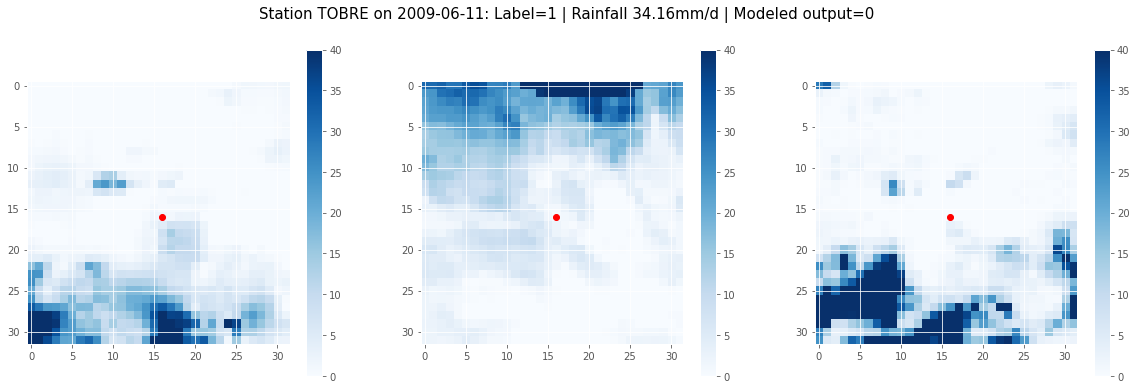

In [34]:
# select random image
ix = oth[random.randint(0, len(oth))].astype(int)
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ix] ][0]

# set minimum and maximum in colorbars
prec_max = max( np.max(input_st_CMORPH[ix,:,:]) * m_CMORPH, np.max(input_st_TAMSAT[ix,:,:]) * m_TAMSAT, np.max(input_st_IMERG[ix,:,:]) * m_IMERG )
prec_max = min(prec_max, 40)  # set a threshold so it can be visible


# FOR index = IX
if y[ ix ] == 0.0:
  modeled_output = 1.0
else:
  modeled_output = 0.0


# create subplots
plt.figure(figsize=(20, 6))
plt.suptitle(f'Station {station} on {df.index[ ix ].date()}: Label={y[ ix ]:.0f} | Rainfall {prec[ ix ]:.2f}mm/d | Modeled output={modeled_output:.0f}', fontsize=15)
plt.subplot()


plt.subplot(131)
img = input_st_CMORPH[ix, :, :] * m_CMORPH
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
# plt.title(f'CMORPH output={y_mod_CMORPH[ix][0]:.2f} out of 1.')  


plt.subplot(132)
img = input_st_TAMSAT[ix, :, :] * m_TAMSAT
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
# plt.title(f'TAMSAT output={y_mod_TAMSAT[ix][0]:.2f} out of 1.')   


plt.subplot(133)
img = input_st_IMERG[ix, :, :] * m_IMERG
# plot image
plt.imshow(img, vmin=0, vmax=prec_max, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar();
# plt.title(f'IMERG output={y_mod_IMERG[ix][0]:.2f} out of 1.')